#YΣ19 Artificial Intelligence II (Deep Learning for Natural Language Processing)
#Homework 1
Καμπέρη Πέτρος- Φώτης 
ΑΜ 1115 2017 00043



#1. Import needed libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import string
import re


#2. Import the Dataset

In [4]:
#load dataset into a dataframe
train_df = pd.read_csv("/content/vaccine_train_set.csv",  )
validation_df = pd.read_csv("/content/vaccine_validation_set.csv",  )

#3 Data preprocessing

In [5]:
def preprocess(df):

    tweets = df['tweet'].str.lower() #turn words into lowercase
    tweets = tweets.str.replace('http\S+|www.\S+', '', case=False) #remove urls
    tweets = tweets.str.replace(r"\\\w+", "") #remove strings starting with \ (backslash)
    tweets = tweets.apply(lambda x : " ".join(re.findall('[\w]+',x))) #remove punctuation
    tweets = tweets.str.replace('\d+', '') #remove numbers
    tweets = tweets.apply(lambda x : re.sub(r'\b[a-zA-Z]\b','', x)) #remove single letters
    return tweets

train_tweets = preprocess(train_df)
val_tweets = preprocess(validation_df)

#4. Feature extraction

In [6]:
y_train = train_df['label'].to_numpy()

 # 4.1 With preprocessing

In [7]:
tfidf1 = TfidfVectorizer()
tfidf1.fit(train_tweets)
X_train_tfidf1 =  tfidf1.transform(train_tweets)

 # 4.1 Without preprocessing

In [8]:
tfidf2 = TfidfVectorizer()
tfidf2.fit(train_df['tweet'].str.lower())
X_train_tfidf2 =  tfidf2.transform(train_df['tweet'].str.lower())

#5. Vaccine sentiment classifier using softmax regression

In [9]:
def softmax_regression_classifier(X_train, y_train):
    model = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    parameters = {'C' : [1, 1.5, 2.0, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0], 'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga']}
    search = GridSearchCV(model, parameters, scoring='f1_weighted', n_jobs=-1, cv = cv, verbose = True)
    result = search.fit(X_train,y_train) 
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    return result

#6. Classifier evaluation

In [10]:
y_val = validation_df['label']

#6.1 With preprocessing

In [11]:
clf1 = softmax_regression_classifier(X_train_tfidf1, y_train)

X_val1  = val_tweets
X_val_tfidf1 = tfidf1.transform(X_val1)

y_pred1 = clf1.predict(X_val_tfidf1)

print(classification_report(y_val,y_pred1))
print("Accuracy score: {}".format(round(accuracy_score(y_val,y_pred1),3)))

Fitting 30 folds for each of 36 candidates, totalling 1080 fits
Best Score: 0.7141237672566442
Best Hyperparameters: {'C': 2.8, 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1065
           1       0.62      0.50      0.55       296
           2       0.68      0.74      0.71       921

    accuracy                           0.72      2282
   macro avg       0.69      0.67      0.68      2282
weighted avg       0.72      0.72      0.72      2282

Accuracy score: 0.72


#6.2 Without preprocessing

In [12]:
clf2 = softmax_regression_classifier(X_train_tfidf2, y_train)

X_val2  = validation_df['tweet'].str.lower()
X_val_tfidf2 = tfidf2.transform(X_val2)

y_pred2 = clf2.predict(X_val_tfidf2)

print(classification_report(y_val,y_pred2))
print("Accuracy score: {}".format(round(accuracy_score(y_val,y_pred2),3)))

Fitting 30 folds for each of 36 candidates, totalling 1080 fits
Best Score: 0.7162447777528963
Best Hyperparameters: {'C': 2.7, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1065
           1       0.62      0.50      0.55       296
           2       0.68      0.76      0.71       921

    accuracy                           0.72      2282
   macro avg       0.70      0.67      0.68      2282
weighted avg       0.72      0.72      0.72      2282

Accuracy score: 0.723


Seeing the results above, we can notice that further preprocessing the data, apart from turning the tweets' text into lowercase, does not contribute to a significant improvement or difference in the performance of the classifier.  In any case, the results are sufficiently satisfactory and thus there is no overfitting or underfitting.

#7. Plotting learning curves

#7.1 With preprocessing

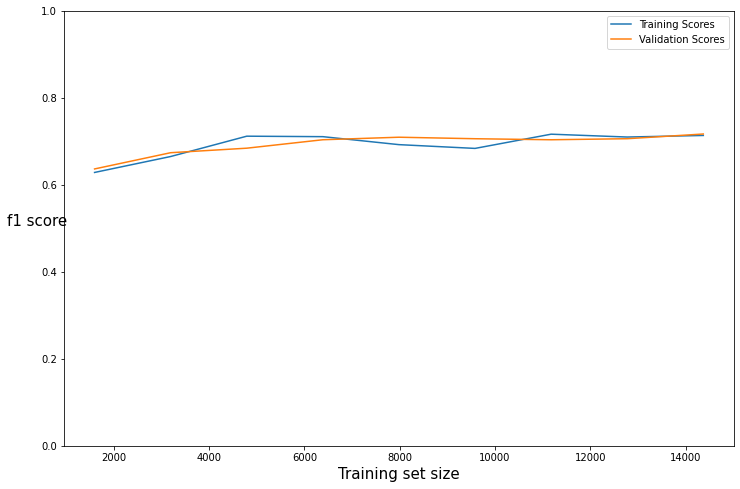

In [13]:
sizes = [i * (len(train_df) // 10) for i in range (1,10)]


training_scores = []
validation_scores = []

for size in sizes:

    sample = train_df.sample(n = size)

    X_train, X_test, y_train, y_test = train_test_split(preprocess(sample),sample['label'])
        
    tfidf = TfidfVectorizer()
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    classifier = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2', C = clf1.best_params_['C'], solver = clf1.best_params_['solver'])

  
    classifier.fit(X_train_tfidf,y_train) 

    y_pred = classifier.predict(X_test_tfidf)
    score = f1_score(y_test, y_pred, average='weighted')
    training_scores.append(score)
        
    X_val_tfidf1 = tfidf.transform(X_val1)
    y_pred = classifier.predict(X_val_tfidf1)
    score = f1_score(y_val, y_pred, average='weighted')
    validation_scores.append(score)

plt.figure(figsize = (12,8))
plt.plot(sizes, training_scores, label='Training Scores')
plt.plot(sizes, validation_scores, label="Validation Scores")
plt.legend(loc='best')
plt.gca().set_ylim([0,1])
plt.xlabel("Training set size", fontsize=15)
plt.ylabel("f1 score", rotation=0, fontsize=15)
plt.show()

According to theory we can conclude that our model is not overfitting or undrfitting.

#7.2 Without preprocessing

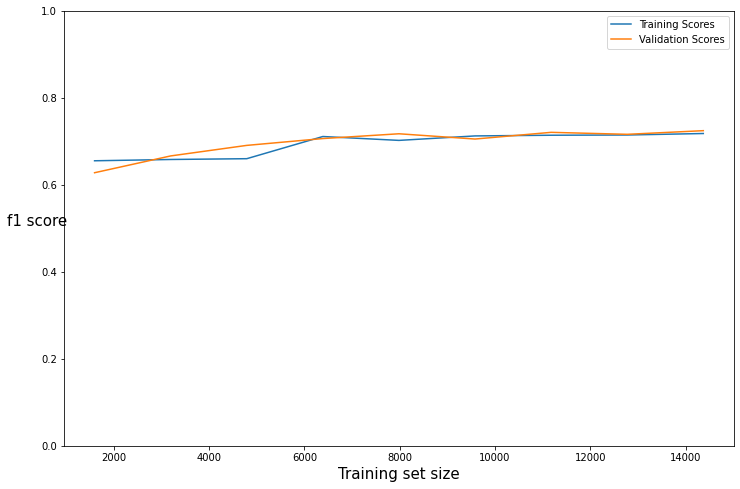

In [14]:
sizes = [i * (len(train_df) // 10) for i in range (1,10)]


training_scores = []
validation_scores = []

for size in sizes:

    sample = train_df.sample(n = size)

    X_train, X_test, y_train, y_test = train_test_split(sample['tweet'].str.lower(),sample['label'])
        
    tfidf = TfidfVectorizer()
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    classifier = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2', C = clf2.best_params_['C'], solver = clf2.best_params_['solver'])
  
    classifier.fit(X_train_tfidf,y_train) 

    y_pred = classifier.predict(X_test_tfidf)
    score = f1_score(y_test, y_pred, average='weighted')
    training_scores.append(score)
        
    X_val_tfidf2 = tfidf.transform(X_val2)
    y_pred = classifier.predict(X_val_tfidf2)
    score = f1_score(y_val, y_pred, average='weighted')
    validation_scores.append(score)

plt.figure(figsize = (12,8))
plt.plot(sizes, training_scores, label='Training Scores')
plt.plot(sizes, validation_scores, label="Validation Scores")
plt.legend(loc='best')
plt.gca().set_ylim([0,1])
plt.xlabel("Training set size", fontsize=15)
plt.ylabel("f1 score", rotation=0, fontsize=15)
plt.show()


According to theory we can conclude that our model is not overfitting or undrfitting.

#8. Experiments: C parameter and f1 score

#8.1 With preprocessing

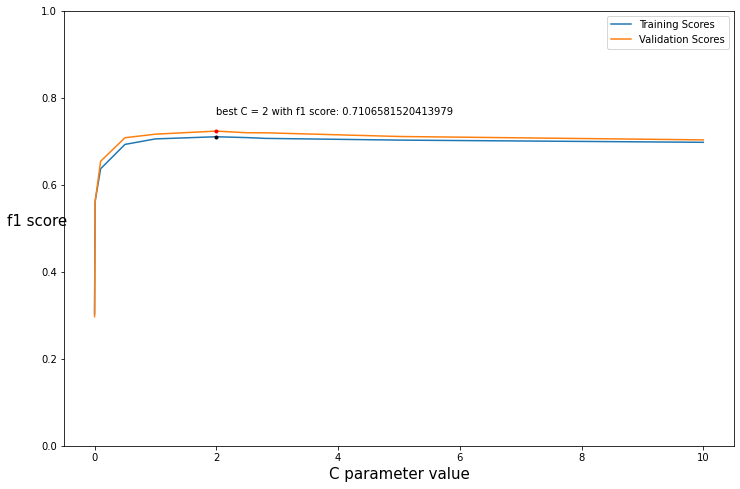

In [15]:
c_vals = [0.001, 0.01, 0.1, 0.5, 1, 2, 2.5, 2.8, 5, 10]

training_scores = []
validation_scores = []

X_train, X_test, y_train, y_test = train_test_split(preprocess(train_df),train_df['label'])
X_val  = preprocess(validation_df)
y_val = validation_df['label'].to_numpy()

for c in c_vals:

    
    tfidf = TfidfVectorizer()
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    classifier = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2', C = c, solver = clf1.best_params_['solver'])
  
    classifier.fit(X_train_tfidf,y_train) 

    y_pred = classifier.predict(X_test_tfidf)
    score = f1_score(y_test, y_pred, average='weighted')
    training_scores.append(score)
        
    X_val_tfidf = tfidf.transform(X_val)
    y_pred = classifier.predict(X_val_tfidf)
    score = f1_score(y_val, y_pred, average='weighted')
    validation_scores.append(score)    

pos = 0
for x in training_scores:
    if x == max(training_scores):
        break
    pos +=1  


plt.figure(figsize = (12,8))
plt.plot(c_vals, training_scores, label='Training Scores')
plt.plot(c_vals, validation_scores, label="Validation Scores")
plt.plot(c_vals[pos], training_scores[pos], marker='o', markersize=3, color="black")
plt.plot(c_vals[pos], validation_scores[pos], marker='o', markersize=3, color="red")
plt.annotate("best C = " + str(c_vals[pos]) +" with f1 score: " + str( training_scores[pos]), (c_vals[pos], training_scores[pos]), (c_vals[pos], training_scores[pos] +0.05))
plt.legend(loc='best')
plt.gca().set_ylim([0,1])
plt.xlabel("C parameter value", fontsize=15)
plt.ylabel("f1 score", rotation=0, fontsize=15)
plt.show()

As we can see the optimal C value (approximately) matches the one found via grid search

#8.2 Without preprocessing

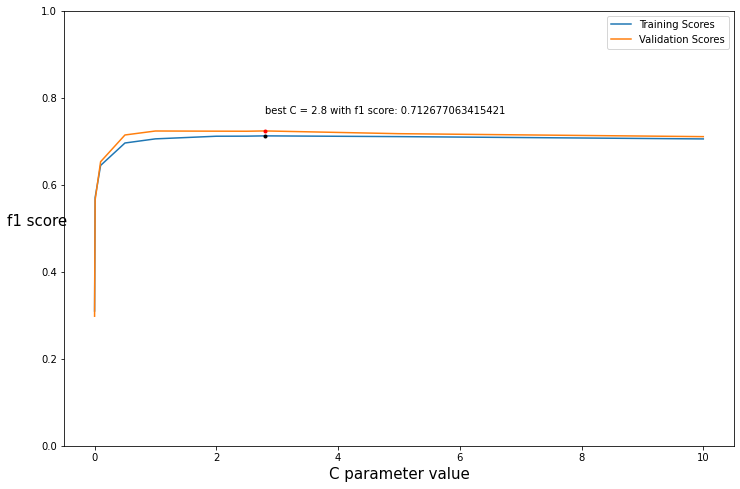

In [16]:
c_vals = [0.001, 0.01, 0.1, 0.5, 1,  2, 2.5, 2.8, 5, 10]

training_scores = []
validation_scores = []

X_train, X_test, y_train, y_test = train_test_split(train_df['tweet'].str.lower(),train_df['label'])
X_val  = validation_df['tweet'].str.lower()
y_val = validation_df['label'].to_numpy()

for c in c_vals:

    
    tfidf = TfidfVectorizer()
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    classifier = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2', C = c, solver = clf2.best_params_['solver'])
  
    classifier.fit(X_train_tfidf,y_train) 

    y_pred = classifier.predict(X_test_tfidf)
    score = f1_score(y_test, y_pred, average='weighted')
    training_scores.append(score)
        
    X_val_tfidf = tfidf.transform(X_val)
    y_pred = classifier.predict(X_val_tfidf)
    score = f1_score(y_val, y_pred, average='weighted')
    validation_scores.append(score)    

pos = 0
for x in training_scores:
    if x == max(training_scores):
        break
    pos +=1  


plt.figure(figsize = (12,8))
plt.plot(c_vals, training_scores, label='Training Scores')
plt.plot(c_vals, validation_scores, label="Validation Scores")
plt.plot(c_vals[pos], training_scores[pos], marker='o', markersize=3, color="black")
plt.plot(c_vals[pos], validation_scores[pos], marker='o', markersize=3, color="red")
plt.annotate("best C = " + str(c_vals[pos]) +" with f1 score: " + str( training_scores[pos]), (c_vals[pos], training_scores[pos]), (c_vals[pos], training_scores[pos] +0.05))
plt.legend(loc='best')
plt.gca().set_ylim([0,1])
plt.xlabel("C parameter value", fontsize=15)
plt.ylabel("f1 score", rotation=0, fontsize=15)
plt.show()

As we can see the optimal C value  matches the one found via grid search

#9. Method implementing the softmax regression classifier unifying all the previous steps.

In [17]:
def vaccine_sentiment_classifier(training_set_path, validation_set_path, parameters = {}, preprocessing = 0):
    
    #load dataset into a dataframe
    train_df = pd.read_csv(training_set_path)
    validation_df = pd.read_csv(validation_set_path)

    if(preprocessing):
        X_train = preprocess(train_df)
        y_train = train_df['label'].to_numpy()

        X_val  = preprocess(validation_df)
        y_val = validation_df['label'].to_numpy()
    else:
        X_train = train_df['tweet'].str.lower()
        y_train = train_df['label'].to_numpy()

        X_val  = validation_df['tweet'].str.lower() 
        y_val = validation_df['label'].to_numpy()

    #feature extraction
    tfidf = TfidfVectorizer()
    tfidf.fit(X_train)
    X_train_tfidf =  tfidf.transform(X_train)
    X_val_tfidf = tfidf.transform(X_val)

    #softmax regression
    model = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2')
    if len(parameters):
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        search = GridSearchCV(model, parameters, scoring='f1_weighted', n_jobs=-1, cv = cv)
        result = search.fit(X_train_tfidf,y_train) 
        print('Best Score: %s' % result.best_score_)
        print('Best Hyperparameters: %s' % result.best_params_)
    else:
        result = model.fit(X_train_tfidf,y_train) 

    y_pred = result.predict(X_val_tfidf)
    print(classification_report(y_val,y_pred))
    
    print("Accuracy score: {}".format(round(accuracy_score(y_val,y_pred),3)))

    #learning curves

    sizes = [i * (len(train_df) // 10) for i in range (1,10)]


    training_scores = []
    validation_scores = []

    for size in sizes:

        sample = train_df.sample(n = size)

        if(preprocessing):
            X_train, X_test, y_train, y_test = train_test_split(preprocess(sample),sample['label'])
        else:
            X_train, X_test, y_train, y_test = train_test_split(sample['tweet'].str.lower(),sample['label'])
        
        tfidf = TfidfVectorizer()
        tfidf.fit(X_train)
        X_train_tfidf = tfidf.transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)
        if len(parameters):
            classifier = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2', C = result.best_params_['C'], solver = result.best_params_['solver'])
        else:
            classifier = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2')
  
        classifier.fit(X_train_tfidf,y_train) 

        y_pred = classifier.predict(X_test_tfidf)
        score = f1_score(y_test, y_pred, average='weighted')
        training_scores.append(score)
        
        X_val_tfidf = tfidf.transform(X_val)
        y_pred = classifier.predict(X_val_tfidf)
        score = f1_score(y_val, y_pred, average='weighted')
        validation_scores.append(score)

    plt.figure(figsize = (12,8))
    plt.plot(sizes, training_scores, label='Training Scores')
    plt.plot(sizes, validation_scores, label="Validation Scores")
    plt.legend(loc='best')
    plt.gca().set_ylim([0,1])
    plt.xlabel("Training set size", fontsize=15)
    plt.ylabel("f1 score", rotation=0, fontsize=15)
    plt.show()


##Example method calls

Best Score: 0.7140191202215539
Best Hyperparameters: {'C': 2.8, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1065
           1       0.62      0.50      0.55       296
           2       0.68      0.74      0.71       921

    accuracy                           0.72      2282
   macro avg       0.69      0.67      0.68      2282
weighted avg       0.72      0.72      0.72      2282

Accuracy score: 0.72


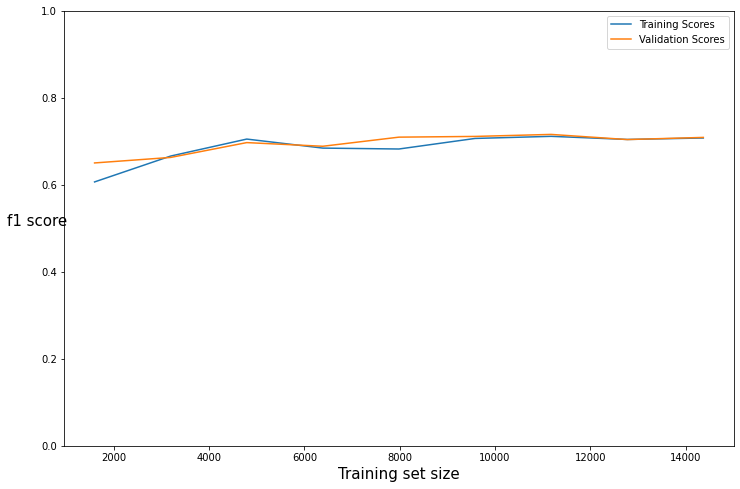

In [18]:
vaccine_sentiment_classifier("/content/vaccine_train_set.csv", "/content/vaccine_validation_set.csv",{'C' : [1.0, 2.0, 2.5, 2.6, 2.7, 2.8], 'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga']}, 1)

Best Score: 0.7162447777528963
Best Hyperparameters: {'C': 2.7, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1065
           1       0.62      0.50      0.55       296
           2       0.68      0.76      0.71       921

    accuracy                           0.72      2282
   macro avg       0.70      0.67      0.68      2282
weighted avg       0.72      0.72      0.72      2282

Accuracy score: 0.723


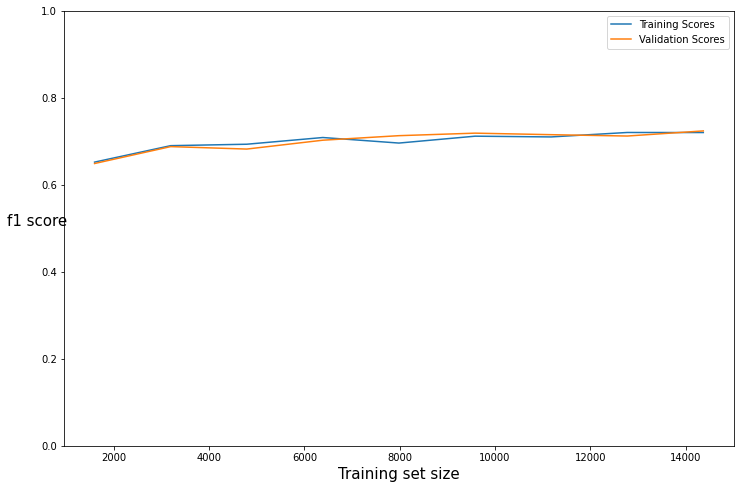

In [19]:
vaccine_sentiment_classifier("/content/vaccine_train_set.csv", "/content/vaccine_validation_set.csv",{'C' : [1.0, 2.0, 2.5, 2.6, 2.7, 2.8], 'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga']})

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1065
           1       0.65      0.43      0.52       296
           2       0.68      0.76      0.72       921

    accuracy                           0.73      2282
   macro avg       0.71      0.66      0.67      2282
weighted avg       0.73      0.73      0.72      2282

Accuracy score: 0.726


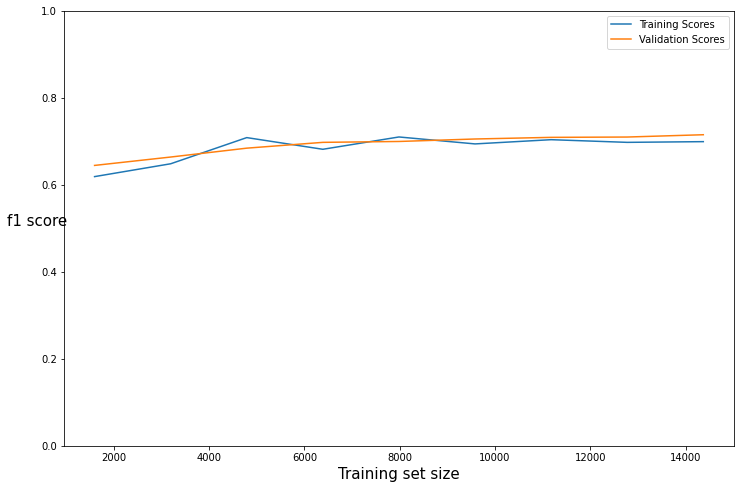

In [20]:
vaccine_sentiment_classifier("/content/vaccine_train_set.csv", "/content/vaccine_validation_set.csv", {} ,1)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1065
           1       0.66      0.44      0.53       296
           2       0.68      0.77      0.72       921

    accuracy                           0.73      2282
   macro avg       0.71      0.66      0.68      2282
weighted avg       0.73      0.73      0.72      2282

Accuracy score: 0.729


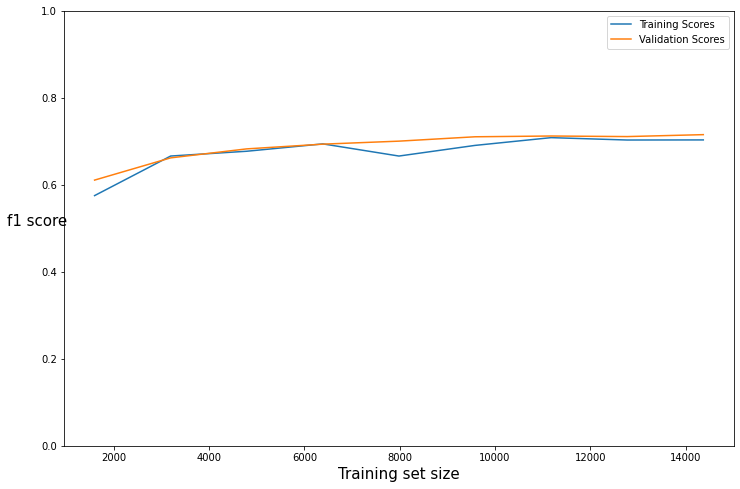

In [21]:
vaccine_sentiment_classifier("/content/vaccine_train_set.csv", "/content/vaccine_validation_set.csv")

According to theory we can conclude that none of the previous models is either overfitting or undrfitting.